In [ ]:
!unzip Images.zip

In [ ]:
!unzip Airplanes_Annotations.zip

In [ ]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
path = "Images"
annot = "Airplanes_Annotations"

airplane_188.jpg
[[[220 219 215]
  [219 218 214]
  [216 215 211]
  ...
  [182 178 173]
  [173 169 164]
  [147 143 138]]

 [[221 220 216]
  [219 218 214]
  [216 215 211]
  ...
  [168 164 159]
  [153 149 144]
  [150 146 141]]

 [[221 220 216]
  [219 218 214]
  [216 215 211]
  ...
  [131 128 120]
  [159 156 148]
  [164 161 153]]

 ...

 [[168 162 149]
  [167 159 146]
  [165 155 145]
  ...
  [126 112 100]
  [120 106  94]
  [138 124 112]]

 [[166 158 145]
  [160 152 139]
  [155 146 133]
  ...
  [133 119 107]
  [124 110  98]
  [122 108  96]]

 [[158 150 137]
  [151 143 130]
  [145 133 121]
  ...
  [114 100  88]
  [107  93  81]
  [105  91  79]]]
                 1
0  172 212 230 253


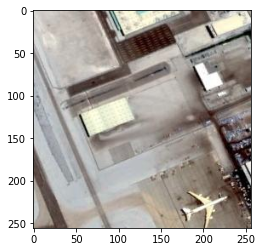

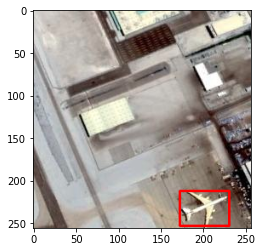

In [ ]:
for e,i in enumerate(os.listdir(annot)):
    if e < 10:
        filename = i.split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(path,filename))
        df = pd.read_csv(os.path.join(annot,i))
        plt.imshow(img)
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
        plt.figure()
        plt.imshow(img)
        break

- setUseOptimized : Turns on/off available optimization. The function turns on or off the optimized code in OpenCV. Some optimization can not be enabled or disabled, but, for example, most of SSE code in OpenCV can be temporarily turned on or off this way.

In [ ]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

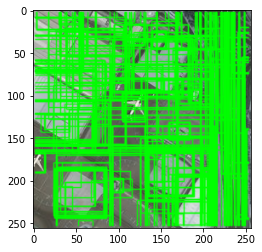

In [ ]:
im = cv2.imread(os.path.join(path,"42850.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

In [ ]:
train_images=[]
train_labels=[]

In [ ]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

무작위로 그려진 selective_segmentation 중에서 좌표와 멀면 0 , 좌표와 가까우면 1으로 레이블 설정

In [ ]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            # Set a image used by switch functions to initialize the class    
            ss.setBaseImage(image)
            # Switch to fast but low recall Selective Search method
            ss.switchToSelectiveSearchFast()
            # run selective search segmentation on input image
            ssresults = ss.process()
            # 출력할 이미지생성
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            # 원본이미지에 그려진 search segmentation의 수만큼 순회
            for e,result in enumerate(ssresults):
                # 
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        # search segmentation의 왼쪽 상단좌표와 width, height취득
                        x,y,w,h = result
                        # 
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

In [ ]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [ ]:
X_new.shape

(30229, 224, 224, 3)

In [ ]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [ ]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

553476096/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

In [ ]:
X= vggmodel.layers[-2].output

In [ ]:
predictions = Dense(2, activation="softmax")(X)

In [ ]:
model_final = Model(inputs = vggmodel.input, outputs = predictions)

In [ ]:
from tensorflow import keras
opt = keras.optimizers.Adam(learning_rate=0.01)

In [ ]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

In [ ]:
model_final.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [ ]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [ ]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [ ]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [ ]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(27206, 224, 224, 3) (3023, 224, 224, 3) (27206, 2) (3023, 2)


In [ ]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

ModelCheckpoint : [https://deep-deep-deep.tistory.com/53](https://deep-deep-deep.tistory.com/53)
### <수정 사항>
- `period=1` => `save_freq='epoch'`


In [ ]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

- `Model.fit_generator(generator= traindata, .... )` => `Model.fit(traindata, .....)`

In [ ]:
hist = model_final.fit(traindata, steps_per_epoch= 10, epochs= 1000, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

Epoch 1/1000
10/10 [==============================] - 16s 2s/step - loss: 0.3389 - accuracy: 0.8656 - val_loss: 0.2595 - val_accuracy: 0.9062

Epoch 00001: val_loss improved from inf to 0.25948, saving model to ieeercnn_vgg16_1.h5
Epoch 2/1000
10/10 [==============================] - 16s 2s/step - loss: 0.3165 - accuracy: 0.8687 - val_loss: 0.2388 - val_accuracy: 0.9062

Epoch 00002: val_loss improved from 0.25948 to 0.23876, saving model to ieeercnn_vgg16_1.h5
Epoch 3/1000
10/10 [==============================] - 17s 2s/step - loss: 0.3252 - accuracy: 0.8813 - val_loss: 0.3030 - val_accuracy: 0.8906

Epoch 00003: val_loss did not improve from 0.23876
Epoch 4/1000
10/10 [==============================] - 16s 2s/step - loss: 0.2953 - accuracy: 0.8969 - val_loss: 0.3140 - val_accuracy: 0.8750

Epoch 00004: val_loss did not improve from 0.23876
Epoch 5/1000
10/10 [==============================] - 16s 2s/step - loss: 0.3378 - accuracy: 0.8375 - val_loss: 0.2869 - val_accuracy: 0.8906

Epo

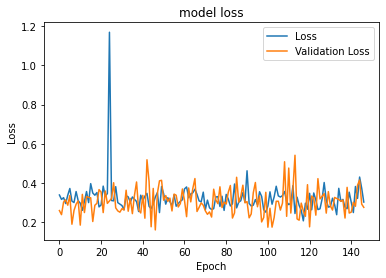

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

plane


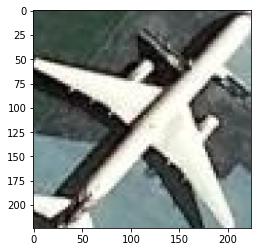

In [ ]:
im = X_test[1600]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("plane")
else:
    print("not plane")

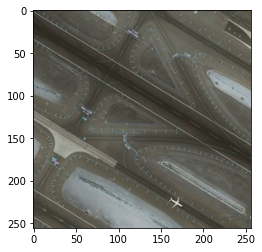

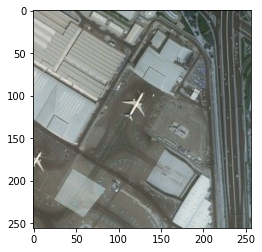

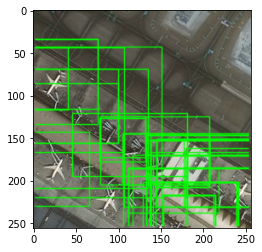

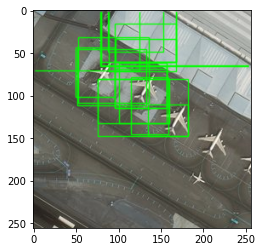

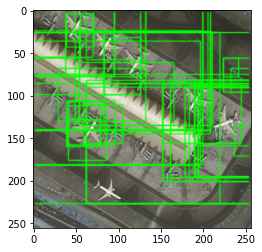

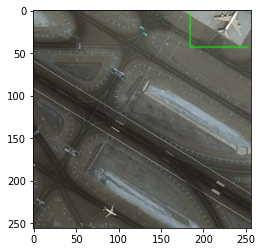

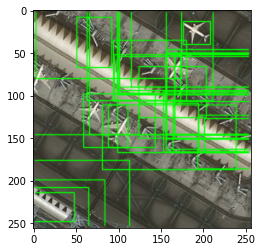

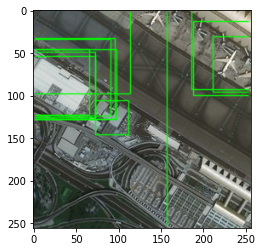

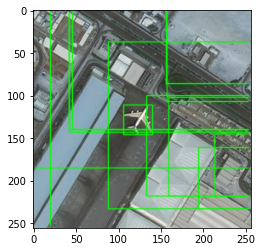

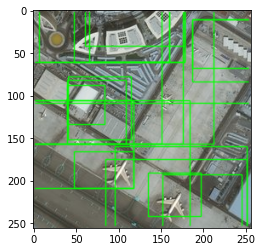

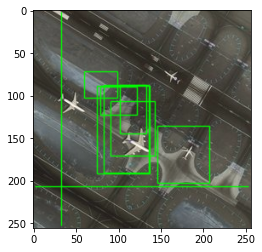

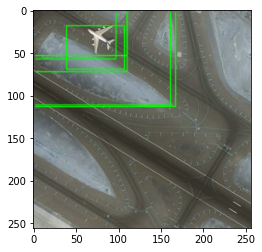

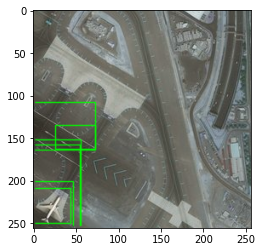

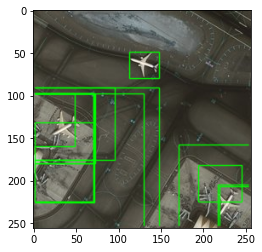

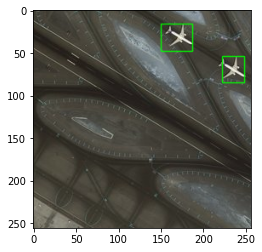

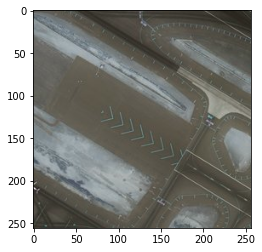

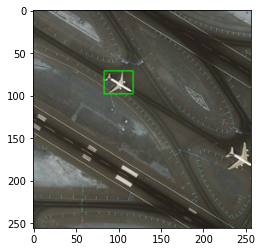

In [ ]:
z=0
for e,i in enumerate(os.listdir(path)):
    if i.startswith("4"):
        z += 1
        img = cv2.imread(os.path.join(path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.65:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)